# Hand Gesture Recognition: Neural Network Training and Evaluation

This notebook details the process of training and evaluating a neural network for hand gesture recognition. The primary goal is to build a robust classifier that can accurately identify different hand gestures from landmark data extracted using MediaPipe.

The process involves:
1.  **Loading Preprocessed Data**: We use datasets of hand landmarks generated by the `data_generation.ipynb` notebook.
2.  **Hyperparameter Tuning**: A systematic search is performed to find the optimal set of hyperparameters for our neural network model.
3.  **Model Training**: The model is trained on the landmark data.
4.  **Evaluation**: The trained model's performance is rigorously evaluated using various metrics and visualizations.
5.  **Saving the Best Model**: The best-performing model is saved for real-time inference in the main application.

### Table of Contents
1. [Setup and Dependencies](#setup)
2. [Model Training and Hyperparameter Tuning](#training)
3. [Performance Analysis of All Variants](#performance-analysis)
4. [In-Depth Evaluation of the Best Model](#evaluation)

<a id="setup"></a>
## 1. Setup and Dependencies

This section ensures that the environment is correctly configured to run the notebook. The following code cell installs all the necessary Python libraries listed in the `requirements.txt` file.

**How to Use:**
1.  Make sure you have Python and `pip` installed.
2.  Run the next cell to install all dependencies.

This notebook relies on data generated by `data_generation.ipynb`. If you haven't run it yet, please do so before proceeding.

In [ ]:
%pip install -r requirements.txt

<a id="training"></a>
## 2. Model Training and Hyperparameter Tuning

This is the core section of the notebook, where we train our gesture classifier. The process is designed to be robust and systematic, incorporating hyperparameter tuning to find the best model configuration.

### The Process

1.  **Load Configuration**: We start by loading application-wide settings from `app_config.json`, which includes paths to datasets and model artifacts, as well as the hyperparameter search space.
2.  **Load Datasets**: The training and validation datasets, which contain the hand landmarks and corresponding gesture IDs, are loaded from CSV files.
3.  **Hyperparameter Grid Search**: We define a grid of hyperparameters to explore. This includes different learning rates, dropout rates, batch sizes, and network architectures. The code iterates through every possible combination of these hyperparameters.
4.  **Train a Model for Each Combination**: For each set of hyperparameters, a new `GestureClassifier` is instantiated and trained. The training process uses the training data (`X_train`, `Y_train`) and evaluates performance on a validation set (`X_val`, `Y_val`) at the end of each epoch.
5.  **Evaluate and Record Performance**: After training, each model variant is evaluated against a separate evaluation dataset (`X_eval`, `Y_eval`). We calculate several regression and classification metrics to assess its performance, including:
    *   **R-squared ($R^2$)**: Measures the proportion of the variance in the dependent variable that is predictable from the independent variable(s).\\ An $R^2$ of 1 indicates that the model perfectly predicts the data.
    *   **Mean Squared Error (MSE)**: The average of the squares of the errors. It is sensitive to large errors.
    *   **Mean Absolute Error (MAE)**: The average of the absolute differences between predictions and actual values. It is less sensitive to outliers than MSE.
6.  **Identify and Save the Best Model**: After all variants have been trained and evaluated, we identify the best-performing model based on the highest validation R2-Score and lowest validation loss. This model is then saved to a file (`gesture_model.h5`) for use in the application. All performance metrics are saved to `models_performance.csv`.

In [11]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from src.gesture_controller.gesture_classifier import GestureClassifier
from src.gesture_controller.app_config import AppConfig
import itertools as itertools
import pandas as pd
import numpy as np
import sys
import os

# --- Load Configuration ---
config = AppConfig()
data_generation_config = config.get_app_config("DATA_GENERATION_CONFIG")
datase_train_path = data_generation_config.get("DATASET_TRAINING_PATH")
datase_val_path = data_generation_config.get("DATASET_VAL_PATH")

model_path = config.get_neural_network_config().get('MODEL_PATH')
model_performance_path = config.get_neural_network_config().get('MODEL_PERFORMANCE_PATH')
hyperparam_config = config.get_hyperparameter_config()


# --- Load and Prepare Dataset ---
try:
    # Load training dataset from CSV
    df_train = pd.read_csv(datase_train_path)
    df_train['LANDMARKS'] = df_train['LANDMARKS'].apply(eval)
    X = np.array(df_train['LANDMARKS'].tolist())
    Y = df_train['GESTURE_ID']

    # Load validation/evaluation dataset from CSV
    df_eval = pd.read_csv(datase_val_path)
    df_eval['LANDMARKS'] = df_eval['LANDMARKS'].apply(eval)
    X_eval = np.array(df_eval['LANDMARKS'].tolist())
    Y_eval = df_eval['GESTURE_ID']

    # Dynamically determine number of classes based on highest gesture ID
    max_gesture_id = Y.max()
    num_classes = max_gesture_id + 1

    # Split the data into training and validation sets
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=0.2, random_state=42
    )

    # --- Hyperparameter Tuning ---
    hyperparam_keys = list(hyperparam_config.keys())
    hyperparam_values = list(hyperparam_config.values())

    # Generate all combinations
    hyperparam_combinations = list(itertools.product(*hyperparam_values))

    print(f"Total hyperparameter combinations: {len(hyperparam_combinations)}")

    training_history = []
    best_model = None
    best_val_accuracy = 0
    best_val_loss = float('inf')

    # Iterate over all hyperparameter combinations
    for i, params in enumerate(hyperparam_combinations):
        
        hyperparams = dict(zip(hyperparam_keys, params))
        
        print(f"--- Training Variant {i+1}/{len(hyperparam_combinations)} ---")
        print(f"Hyperparameters: {hyperparams}")
        
        # Create a new classifier for each hyperparameter combination
        classifier = GestureClassifier(num_classes=num_classes, input_size=X_train.shape[1], hyperparams=hyperparams)

        # Train the model
        model, history = classifier.train(
            X_train, Y_train, X_val, Y_val, 
            batch_size=hyperparams['BATCH_SIZE'], 
            epochs=hyperparams['EPOCHS']
        )

        Y_pred = classifier.evaluate(X_eval)

        score_val_accuracy = history.history['val_accuracy'][-1]
        score_val_loss = history.history['val_loss'][-1]
        score_val_r2 = r2_score(Y_eval, Y_pred)
        score_val_mse = mean_squared_error(Y_eval, Y_pred)
        score_val_mae = mean_absolute_error(Y_eval, Y_pred)
        score_val_mape = mean_absolute_percentage_error(Y_eval, Y_pred)
        
        print(f"R2 Score: {score_val_r2:.4f}")
        print(f"MSE: {score_val_mse:.4f}")
        print(f"MAE: {score_val_mae:.4f}")
        print(f"MAPE: {score_val_mape:.4f}")

        # Store history
        run_info = {
            'variant': i + 1,
            'hyperparameters': hyperparams,
            'val_accuracy': score_val_accuracy,
            'val_loss': score_val_loss,
            'val_r2': score_val_r2,
            'val_mse': score_val_mse,
            'val_mae': score_val_mae,
            'val_mape': score_val_mape,
            'history': history.history,
            'model': model
        }
        training_history.append(run_info)

    # Display results
    history_df = pd.DataFrame(training_history)
    history_df.to_csv(model_performance_path)

    best_run = min(training_history, key=lambda x: (1 - x['val_r2'], x['val_loss']))
    
    print("\n--- Best Model Found ---")
    print(f"Parameters: {best_run['hyperparameters']}")
    print(f"R2 Score: {best_run['val_r2']:.4f}")
    print(f"MSE: {best_run['val_mse']:.4f}")
    print(f"MAE: {best_run['val_mae']:.4f}")
    print(f"MAPE: {best_run['val_mape']:.4f}")
    
    best_run['model'].save(model_path)


except FileNotFoundError:
    print(f"Error: Dataset file not found at '{datase_train_path}'.")
    print("Please run the data generation notebook first.")
except Exception as e:
    print(f"An error occurred: {e}")

Total hyperparameter combinations: 72
--- Training Variant 1/72 ---
Hyperparameters: {'DENSE_LAYERS': [128, 64, 32], 'ACTIVATION': 'relu', 'DROPOUT_RATE': 0.2, 'LEARNING_RATE': 0.01, 'BATCH_SIZE': 32, 'EPOCHS': 50}


Model: "sequential_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_576 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_577 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_288 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_578 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_289 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_579 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8228 - loss: 0.4386 - val_accuracy: 0.8945 - val_loss: 0.2992
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8228 - loss: 0.4386 - val_accuracy: 0.8945 - val_loss: 0.2992
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9825 - loss: 0.0617 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9825 - loss: 0.0617 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.9944 - loss: 0.0194 - val_accuracy: 0.9955 - val_loss: 0.0144
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.9944 - loss: 0.0194 - val_accuracy: 0.9955 - val_loss: 0.0144
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.9900 - loss: 0.0370 - val_accuracy: 0.9733 - val_loss: 0.0630
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.9900 - loss: 0.0370 - val_accuracy: 0.9733 - v

Model: "sequential_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_580 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_581 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_290 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_582 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_291 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_583 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7337 - loss: 0.6520 - val_accuracy: 0.9955 - val_loss: 0.0653
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7337 - loss: 0.6520 - val_accuracy: 0.9955 - val_loss: 0.0653
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9859 - loss: 0.0580 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9859 - loss: 0.0580 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9970 - loss: 0.0109 - val_accuracy: 1.0000 - val_loss: 5.5906e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9970 - loss: 0.0109 - val_accuracy: 1.0000 - val_loss: 5.5906e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9944 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9944 - loss: 0.0214 - val_accuracy: 1.0000 - v

Model: "sequential_146"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_584 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_585 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_292 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_586 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_293 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_587 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6315 - loss: 1.0629 - val_accuracy: 0.9064 - val_loss: 0.3467
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6315 - loss: 1.0629 - val_accuracy: 0.9064 - val_loss: 0.3467
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.9023 - loss: 0.3067 - val_accuracy: 0.9985 - val_loss: 0.0647
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.9023 - loss: 0.3067 - val_accuracy: 0.9985 - val_loss: 0.0647
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.9792 - loss: 0.1009 - val_accuracy: 0.9985 - val_loss: 0.0148
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.9792 - loss: 0.1009 - val_accuracy: 0.9985 - val_loss: 0.0148
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.9915 - loss: 0.0454 - val_accuracy: 0.9985 - val_loss: 0.0090
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.9915 - loss: 0.0454 - val_accuracy: 0.9985

Model: "sequential_147"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_588 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_589 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_294 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_590 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_295 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_591 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5074 - loss: 1.5386 - val_accuracy: 0.7890 - val_loss: 0.8419
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5074 - loss: 1.5386 - val_accuracy: 0.7890 - val_loss: 0.8419
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7968 - loss: 0.6455 - val_accuracy: 0.9896 - val_loss: 0.2537
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7968 - loss: 0.6455 - val_accuracy: 0.9896 - val_loss: 0.2537
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9034 - loss: 0.3075 - val_accuracy: 0.9985 - val_loss: 0.0803
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9034 - loss: 0.3075 - val_accuracy: 0.9985 - val_loss: 0.0803
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9647 - loss: 0.1513 - val_accuracy: 0.9985 - val_loss: 0.0242
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9647 - loss: 0.1513 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_148"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_592 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_593 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_296 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_594 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_297 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_595 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7727 - loss: 0.5749 - val_accuracy: 0.9168 - val_loss: 0.1812
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7727 - loss: 0.5749 - val_accuracy: 0.9168 - val_loss: 0.1812
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.9606 - loss: 0.1199 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.9606 - loss: 0.1199 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.9799 - loss: 0.0546 - val_accuracy: 0.9926 - val_loss: 0.0300
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.9799 - loss: 0.0546 - val_accuracy: 0.9926 - val_loss: 0.0300
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.9896 - loss: 0.0358 - val_accuracy: 0.9955 - val_loss: 0.0242
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.9896 - loss: 0.0358 - val_accuracy: 0.9955

Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_596 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_597 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_298 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_598 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_299 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_599 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7229 - loss: 0.7073 - val_accuracy: 0.9985 - val_loss: 0.0298
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7229 - loss: 0.7073 - val_accuracy: 0.9985 - val_loss: 0.0298
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9554 - loss: 0.1276 - val_accuracy: 0.9955 - val_loss: 0.0168
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9554 - loss: 0.1276 - val_accuracy: 0.9955 - val_loss: 0.0168
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9792 - loss: 0.0588 - val_accuracy: 0.9970 - val_loss: 0.0123
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9792 - loss: 0.0588 - val_accuracy: 0.9970 - val_loss: 0.0123
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9874 - loss: 0.0456 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9874 - loss: 0.0456 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_600 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_601 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_300 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_602 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_301 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_603 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5639 - loss: 1.2492 - val_accuracy: 0.9673 - val_loss: 0.4165
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5639 - loss: 1.2492 - val_accuracy: 0.9673 - val_loss: 0.4165
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.8135 - loss: 0.4921 - val_accuracy: 0.9985 - val_loss: 0.1292
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.8135 - loss: 0.4921 - val_accuracy: 0.9985 - val_loss: 0.1292
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.9264 - loss: 0.2505 - val_accuracy: 0.9985 - val_loss: 0.0384
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.9264 - loss: 0.2505 - val_accuracy: 0.9985 - val_loss: 0.0384
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.9707 - loss: 0.1253 - val_accuracy: 0.9985 - val_loss: 0.0107
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.9707 - loss: 0.1253 - val_accuracy: 0.9985

Model: "sequential_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_604 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_605 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_302 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_606 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_303 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_607 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4673 - loss: 1.6070 - val_accuracy: 0.6716 - val_loss: 0.9247
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4673 - loss: 1.6070 - val_accuracy: 0.6716 - val_loss: 0.9247
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6720 - loss: 0.8662 - val_accuracy: 0.9287 - val_loss: 0.4166
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6720 - loss: 0.8662 - val_accuracy: 0.9287 - val_loss: 0.4166
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8165 - loss: 0.5250 - val_accuracy: 0.9926 - val_loss: 0.1826
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8165 - loss: 0.5250 - val_accuracy: 0.9926 - val_loss: 0.1826
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9001 - loss: 0.3254 - val_accuracy: 1.0000 - val_loss: 0.0736
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9001 - loss: 0.3254 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_608 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_609 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_304 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_610 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_305 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_611 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6467 - loss: 0.8080 - val_accuracy: 0.9896 - val_loss: 0.1442
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6467 - loss: 0.8080 - val_accuracy: 0.9896 - val_loss: 0.1442
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.8889 - loss: 0.2648 - val_accuracy: 0.9851 - val_loss: 0.0390
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.8889 - loss: 0.2648 - val_accuracy: 0.9851 - val_loss: 0.0390
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.9335 - loss: 0.1843 - val_accuracy: 0.9896 - val_loss: 0.0405
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.9335 - loss: 0.1843 - val_accuracy: 0.9896 - val_loss: 0.0405
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.9339 - loss: 0.2012 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.9339 - loss: 0.2012 - val_accuracy: 1.0000

Model: "sequential_153"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_612 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_613 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_306 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_614 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_307 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_615 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5728 - loss: 1.0642 - val_accuracy: 0.9866 - val_loss: 0.1980
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5728 - loss: 1.0642 - val_accuracy: 0.9866 - val_loss: 0.1980
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8588 - loss: 0.3468 - val_accuracy: 0.9985 - val_loss: 0.0201
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8588 - loss: 0.3468 - val_accuracy: 0.9985 - val_loss: 0.0201
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9157 - loss: 0.2195 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9157 - loss: 0.2195 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9350 - loss: 0.1697 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9350 - loss: 0.1697 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_154"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_616 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_617 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_308 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_618 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_309 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_619 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4837 - loss: 1.4514 - val_accuracy: 0.7875 - val_loss: 0.6793
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4837 - loss: 1.4514 - val_accuracy: 0.7875 - val_loss: 0.6793
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.6742 - loss: 0.8026 - val_accuracy: 0.8886 - val_loss: 0.3206
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.6742 - loss: 0.8026 - val_accuracy: 0.8886 - val_loss: 0.3206
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.7834 - loss: 0.5369 - val_accuracy: 0.9881 - val_loss: 0.2079
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.7834 - loss: 0.5369 - val_accuracy: 0.9881 - val_loss: 0.2079
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.8332 - loss: 0.4063 - val_accuracy: 0.9970 - val_loss: 0.1625
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.8332 - loss: 0.4063 - val_accuracy: 0.9970

Model: "sequential_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_620 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_621 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_310 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_622 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_311 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_623 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3447 - loss: 1.7559 - val_accuracy: 0.7177 - val_loss: 1.2005
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3447 - loss: 1.7559 - val_accuracy: 0.7177 - val_loss: 1.2005
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5498 - loss: 1.2129 - val_accuracy: 0.8930 - val_loss: 0.6833
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5498 - loss: 1.2129 - val_accuracy: 0.8930 - val_loss: 0.6833
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6575 - loss: 0.9064 - val_accuracy: 0.9465 - val_loss: 0.4474
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6575 - loss: 0.9064 - val_accuracy: 0.9465 - val_loss: 0.4474
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7318 - loss: 0.7066 - val_accuracy: 0.9866 - val_loss: 0.2540
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7318 - loss: 0.7066 - val_accuracy: 0.9866 - val_loss:

Model: "sequential_156"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_624 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_625 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_312 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_626 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_313 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_627 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8945 - loss: 0.3102 - val_accuracy: 1.0000 - val_loss: 0.0084
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8945 - loss: 0.3102 - val_accuracy: 1.0000 - val_loss: 0.0084
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9996 - loss: 0.0108 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9996 - loss: 0.0108 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9840 - loss: 0.0530 - val_accuracy: 0.9822 - val_loss: 0.0529
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9840 - loss: 0.0530 - val_accuracy: 0.9822 - val_loss: 0.0529
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.9881 - loss: 0.0403 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.9881 - loss: 0.0403 - val_accuracy: 1.0000 - val_l

Model: "sequential_157"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_628 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_629 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_314 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_630 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_315 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_631 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8770 - loss: 0.3748 - val_accuracy: 0.9985 - val_loss: 0.0318
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8770 - loss: 0.3748 - val_accuracy: 0.9985 - val_loss: 0.0318
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0326 - val_accuracy: 0.9985 - val_loss: 0.0087
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0326 - val_accuracy: 0.9985 - val_loss: 0.0087
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9959 - loss: 0.0191 - val_accuracy: 0.9985 - val_loss: 0.0082
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9959 - loss: 0.0191 - val_accuracy: 0.9985 - val_loss: 0.0082
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9985 - val_loss: 0.0041
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_632 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_633 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_316 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_634 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_317 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_635 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7559 - loss: 0.8378 - val_accuracy: 0.9406 - val_loss: 0.3410
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7559 - loss: 0.8378 - val_accuracy: 0.9406 - val_loss: 0.3410
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.9710 - loss: 0.2469 - val_accuracy: 0.9985 - val_loss: 0.1077
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.9710 - loss: 0.2469 - val_accuracy: 0.9985 - val_loss: 0.1077
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.9970 - loss: 0.1042 - val_accuracy: 0.9985 - val_loss: 0.0493
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.9970 - loss: 0.1042 - val_accuracy: 0.9985 - val_loss: 0.0493
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.9989 - loss: 0.0556 - val_accuracy: 0.9985 - val_loss: 0.0284
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.9989 - loss: 0.0556 - val_accuracy: 0.9985

Model: "sequential_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_636 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_637 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_318 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_638 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_319 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_639 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6404 - loss: 1.1415 - val_accuracy: 0.8990 - val_loss: 0.5618
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6404 - loss: 1.1415 - val_accuracy: 0.8990 - val_loss: 0.5618
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9004 - loss: 0.4648 - val_accuracy: 0.9970 - val_loss: 0.2435
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9004 - loss: 0.4648 - val_accuracy: 0.9970 - val_loss: 0.2435
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9829 - loss: 0.2190 - val_accuracy: 0.9985 - val_loss: 0.0995
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9829 - loss: 0.2190 - val_accuracy: 0.9985 - val_loss: 0.0995
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9959 - loss: 0.1102 - val_accuracy: 0.9985 - val_loss: 0.0517
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9959 - loss: 0.1102 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_640 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_641 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_320 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_642 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_321 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_643 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8336 - loss: 0.4298 - val_accuracy: 0.9970 - val_loss: 0.0397
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8336 - loss: 0.4298 - val_accuracy: 0.9970 - val_loss: 0.0397
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9907 - loss: 0.0438 - val_accuracy: 0.9985 - val_loss: 0.0039
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9907 - loss: 0.0438 - val_accuracy: 0.9985 - val_loss: 0.0039
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0122 - val_accuracy: 0.9985 - val_loss: 0.0031
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0122 - val_accuracy: 0.9985 - val_loss: 0.0031
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 3.8521e-04
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 1.0000 - val_l

Model: "sequential_161"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_644 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_645 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_322 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_646 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_323 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_647 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8068 - loss: 0.5427 - val_accuracy: 0.9970 - val_loss: 0.0382
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8068 - loss: 0.5427 - val_accuracy: 0.9970 - val_loss: 0.0382
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0485 - val_accuracy: 0.9985 - val_loss: 0.0105
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0485 - val_accuracy: 0.9985 - val_loss: 0.0105
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9944 - loss: 0.0260 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9944 - loss: 0.0260 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9970 - loss: 0.0194 - val_accuracy: 0.9985 - val_loss: 0.0066
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9970 - loss: 0.0194 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_162"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_648 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_649 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_324 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_650 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_325 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_651 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6835 - loss: 0.9699 - val_accuracy: 0.9302 - val_loss: 0.3925
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6835 - loss: 0.9699 - val_accuracy: 0.9302 - val_loss: 0.3925
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9205 - loss: 0.3591 - val_accuracy: 0.9822 - val_loss: 0.1370
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9205 - loss: 0.3591 - val_accuracy: 0.9822 - val_loss: 0.1370
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.9792 - loss: 0.1679 - val_accuracy: 0.9985 - val_loss: 0.0524
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.9792 - loss: 0.1679 - val_accuracy: 0.9985 - val_loss: 0.0524
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.9929 - loss: 0.0946 - val_accuracy: 0.9985 - val_loss: 0.0264
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.9929 - loss: 0.0946 - val_accuracy: 0.9985 - v

Model: "sequential_163"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_652 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_653 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_326 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_654 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_327 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_655 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5371 - loss: 1.2907 - val_accuracy: 0.9272 - val_loss: 0.6412
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5371 - loss: 1.2907 - val_accuracy: 0.9272 - val_loss: 0.6412
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8224 - loss: 0.6020 - val_accuracy: 0.9941 - val_loss: 0.3463
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8224 - loss: 0.6020 - val_accuracy: 0.9941 - val_loss: 0.3463
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9391 - loss: 0.3503 - val_accuracy: 0.9941 - val_loss: 0.1634
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9391 - loss: 0.3503 - val_accuracy: 0.9941 - val_loss: 0.1634
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9807 - loss: 0.2062 - val_accuracy: 0.9970 - val_loss: 0.0841
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9807 - loss: 0.2062 - val_accuracy: 0.9970 - val_loss:

Model: "sequential_164"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_656 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_657 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_328 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_658 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_329 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_659 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7897 - loss: 0.5574 - val_accuracy: 0.9955 - val_loss: 0.0368
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7897 - loss: 0.5574 - val_accuracy: 0.9955 - val_loss: 0.0368
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.9684 - loss: 0.1202 - val_accuracy: 0.9985 - val_loss: 0.0062
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.9684 - loss: 0.1202 - val_accuracy: 0.9985 - val_loss: 0.0062
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.9874 - loss: 0.0563 - val_accuracy: 0.9970 - val_loss: 0.0085
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.9874 - loss: 0.0563 - val_accuracy: 0.9970 - val_loss: 0.0085
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.9907 - loss: 0.0403 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.9907 - loss: 0.0403 - val_accuracy: 1.0000

Model: "sequential_165"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_660 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_661 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_330 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_662 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_331 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_663 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7207 - loss: 0.7306 - val_accuracy: 1.0000 - val_loss: 0.0532
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7207 - loss: 0.7306 - val_accuracy: 1.0000 - val_loss: 0.0532
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9610 - loss: 0.1431 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9610 - loss: 0.1431 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9918 - loss: 0.0479 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9918 - loss: 0.0479 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9926 - loss: 0.0351 - val_accuracy: 1.0000 - val_loss: 6.1841e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9926 - loss: 0.0351 - val_accuracy: 1.0000 - val_l

Model: "sequential_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_664 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_665 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_332 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_666 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_333 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_667 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5984 - loss: 1.1136 - val_accuracy: 0.9421 - val_loss: 0.4737
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5984 - loss: 1.1136 - val_accuracy: 0.9421 - val_loss: 0.4737
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.8451 - loss: 0.5358 - val_accuracy: 0.9777 - val_loss: 0.1980
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.8451 - loss: 0.5358 - val_accuracy: 0.9777 - val_loss: 0.1980
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.9395 - loss: 0.2925 - val_accuracy: 0.9985 - val_loss: 0.0759
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.9395 - loss: 0.2925 - val_accuracy: 0.9985 - val_loss: 0.0759
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.9807 - loss: 0.1678 - val_accuracy: 1.0000 - val_loss: 0.0335
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.9807 - loss: 0.1678 - val_accuracy: 1.0000

Model: "sequential_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_668 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_669 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_334 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_670 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_335 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_671 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5175 - loss: 1.3758 - val_accuracy: 0.8990 - val_loss: 0.7113
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5175 - loss: 1.3758 - val_accuracy: 0.8990 - val_loss: 0.7113
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7559 - loss: 0.7772 - val_accuracy: 0.9599 - val_loss: 0.3764
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7559 - loss: 0.7772 - val_accuracy: 0.9599 - val_loss: 0.3764
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8782 - loss: 0.4839 - val_accuracy: 0.9837 - val_loss: 0.1920
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8782 - loss: 0.4839 - val_accuracy: 0.9837 - val_loss: 0.1920
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9361 - loss: 0.3260 - val_accuracy: 0.9970 - val_loss: 0.1032
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9361 - loss: 0.3260 - val_accuracy: 0.9970 - val_loss:

Model: "sequential_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_672 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_673 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_336 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_674 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_337 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_675 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4807 - loss: 1.3974 - val_accuracy: 0.8202 - val_loss: 0.5307
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4807 - loss: 1.3974 - val_accuracy: 0.8202 - val_loss: 0.5307
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.8488 - loss: 0.3952 - val_accuracy: 0.9911 - val_loss: 0.1196
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.8488 - loss: 0.3952 - val_accuracy: 0.9911 - val_loss: 0.1196
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.9885 - loss: 0.0978 - val_accuracy: 0.9985 - val_loss: 0.0210
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.9885 - loss: 0.0978 - val_accuracy: 0.9985 - val_loss: 0.0210
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.9918 - loss: 0.0484 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.9918 - loss: 0.0484 - val_accuracy: 1.0000

Model: "sequential_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_676 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_677 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_338 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_678 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_339 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_679 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4027 - loss: 1.5601 - val_accuracy: 0.6761 - val_loss: 0.8421
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4027 - loss: 1.5601 - val_accuracy: 0.6761 - val_loss: 0.8421
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7288 - loss: 0.6342 - val_accuracy: 0.8425 - val_loss: 0.4178
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7288 - loss: 0.6342 - val_accuracy: 0.8425 - val_loss: 0.4178
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8503 - loss: 0.3767 - val_accuracy: 0.9703 - val_loss: 0.1948
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8503 - loss: 0.3767 - val_accuracy: 0.9703 - val_loss: 0.1948
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9647 - loss: 0.1698 - val_accuracy: 1.0000 - val_loss: 0.0508
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9647 - loss: 0.1698 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_170"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_680 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_681 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_340 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_682 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_341 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_683 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1735 - loss: 2.0968 - val_accuracy: 0.2511 - val_loss: 1.9651
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1735 - loss: 2.0968 - val_accuracy: 0.2511 - val_loss: 1.9651
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.3425 - loss: 1.8102 - val_accuracy: 0.6137 - val_loss: 1.5459
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.3425 - loss: 1.8102 - val_accuracy: 0.6137 - val_loss: 1.5459
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.5238 - loss: 1.3941 - val_accuracy: 0.6122 - val_loss: 1.1879
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.5238 - loss: 1.3941 - val_accuracy: 0.6122 - val_loss: 1.1879
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5973 - loss: 1.1122 - val_accuracy: 0.6612 - val_loss: 0.9546
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5973 - loss: 1.1122 - val_accuracy: 0.6612 - v

Model: "sequential_171"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_684 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_685 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_342 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_686 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_343 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_687 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1326 - loss: 2.1740 - val_accuracy: 0.2585 - val_loss: 2.0433
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1326 - loss: 2.1740 - val_accuracy: 0.2585 - val_loss: 2.0433
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1965 - loss: 2.0281 - val_accuracy: 0.3210 - val_loss: 1.9675
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1965 - loss: 2.0281 - val_accuracy: 0.3210 - val_loss: 1.9675
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2972 - loss: 1.9042 - val_accuracy: 0.3848 - val_loss: 1.7934
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2972 - loss: 1.9042 - val_accuracy: 0.3848 - val_loss: 1.7934
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3730 - loss: 1.7249 - val_accuracy: 0.6092 - val_loss: 1.5932
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3730 - loss: 1.7249 - val_accuracy: 0.6092 - val_loss:

Model: "sequential_172"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_688 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_689 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_344 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_690 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_345 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_691 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4458 - loss: 1.4154 - val_accuracy: 0.6999 - val_loss: 0.5978
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4458 - loss: 1.4154 - val_accuracy: 0.6999 - val_loss: 0.5978
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.7195 - loss: 0.5459 - val_accuracy: 0.7281 - val_loss: 0.3946
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.7195 - loss: 0.5459 - val_accuracy: 0.7281 - val_loss: 0.3946
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.7931 - loss: 0.4025 - val_accuracy: 0.9376 - val_loss: 0.2431
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.7931 - loss: 0.4025 - val_accuracy: 0.9376 - val_loss: 0.2431
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.9354 - loss: 0.2185 - val_accuracy: 0.9970 - val_loss: 0.0362
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.9354 - loss: 0.2185 - val_accuracy: 0.9970

Model: "sequential_173"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_692 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_693 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_346 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_694 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_347 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_695 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2979 - loss: 1.8298 - val_accuracy: 0.5379 - val_loss: 1.1602
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2979 - loss: 1.8298 - val_accuracy: 0.5379 - val_loss: 1.1602
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6107 - loss: 0.9219 - val_accuracy: 0.7147 - val_loss: 0.5481
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6107 - loss: 0.9219 - val_accuracy: 0.7147 - val_loss: 0.5481
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7162 - loss: 0.5687 - val_accuracy: 0.7400 - val_loss: 0.4176
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7162 - loss: 0.5687 - val_accuracy: 0.7400 - val_loss: 0.4176
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7444 - loss: 0.4630 - val_accuracy: 0.7266 - val_loss: 0.3903
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7444 - loss: 0.4630 - val_accuracy: 0.7266 - val_loss:

Model: "sequential_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_696 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_697 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_348 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_698 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_349 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_699 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1452 - loss: 2.1351 - val_accuracy: 0.5022 - val_loss: 1.9697
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1452 - loss: 2.1351 - val_accuracy: 0.5022 - val_loss: 1.9697
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.2827 - loss: 1.8812 - val_accuracy: 0.4814 - val_loss: 1.6450
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.2827 - loss: 1.8812 - val_accuracy: 0.4814 - val_loss: 1.6450
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.4268 - loss: 1.5613 - val_accuracy: 0.6627 - val_loss: 1.3417
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.4268 - loss: 1.5613 - val_accuracy: 0.6627 - val_loss: 1.3417
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.5223 - loss: 1.3116 - val_accuracy: 0.6553 - val_loss: 1.1095
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.5223 - loss: 1.3116 - val_accuracy: 0.6553

Model: "sequential_175"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_700 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_701 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_350 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_702 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_351 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_703 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1389 - loss: 2.1718 - val_accuracy: 0.3982 - val_loss: 2.0322
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1389 - loss: 2.1718 - val_accuracy: 0.3982 - val_loss: 2.0322
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1620 - loss: 2.0606 - val_accuracy: 0.5171 - val_loss: 1.9563
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1620 - loss: 2.0606 - val_accuracy: 0.5171 - val_loss: 1.9563
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2600 - loss: 1.9359 - val_accuracy: 0.5468 - val_loss: 1.7902
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2600 - loss: 1.9359 - val_accuracy: 0.5468 - val_loss: 1.7902
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3410 - loss: 1.7516 - val_accuracy: 0.5260 - val_loss: 1.6042
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3410 - loss: 1.7516 - val_accuracy: 0.5260 - val_loss:

Model: "sequential_176"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_704 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_705 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_352 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_706 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_353 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_707 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3336 - loss: 1.7089 - val_accuracy: 0.6464 - val_loss: 0.8300
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3336 - loss: 1.7089 - val_accuracy: 0.6464 - val_loss: 0.8300
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.6579 - loss: 0.7705 - val_accuracy: 0.7311 - val_loss: 0.4466
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.6579 - loss: 0.7705 - val_accuracy: 0.7311 - val_loss: 0.4466
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.7441 - loss: 0.5287 - val_accuracy: 0.9807 - val_loss: 0.2892
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.7441 - loss: 0.5287 - val_accuracy: 0.9807 - val_loss: 0.2892
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.8655 - loss: 0.3524 - val_accuracy: 1.0000 - val_loss: 0.0776
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.8655 - loss: 0.3524 - val_accuracy: 1.0000

Model: "sequential_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_708 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_709 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_354 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_710 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_355 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_711 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2184 - loss: 1.9748 - val_accuracy: 0.5037 - val_loss: 1.6246
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2184 - loss: 1.9748 - val_accuracy: 0.5037 - val_loss: 1.6246
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4450 - loss: 1.4105 - val_accuracy: 0.6226 - val_loss: 0.9410
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4450 - loss: 1.4105 - val_accuracy: 0.6226 - val_loss: 0.9410
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6430 - loss: 0.8704 - val_accuracy: 0.7162 - val_loss: 0.5144
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6430 - loss: 0.8704 - val_accuracy: 0.7162 - val_loss: 0.5144
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7017 - loss: 0.6114 - val_accuracy: 0.8410 - val_loss: 0.3858
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7017 - loss: 0.6114 - val_accuracy: 0.8410 - val_loss:

Model: "sequential_178"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_712 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_713 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_356 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_714 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_357 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_715 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1426 - loss: 2.1822 - val_accuracy: 0.2541 - val_loss: 2.0160
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1426 - loss: 2.1822 - val_accuracy: 0.2541 - val_loss: 2.0160
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.2047 - loss: 2.0135 - val_accuracy: 0.3982 - val_loss: 1.8142
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.2047 - loss: 2.0135 - val_accuracy: 0.3982 - val_loss: 1.8142
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.3139 - loss: 1.7412 - val_accuracy: 0.5171 - val_loss: 1.4811
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.3139 - loss: 1.7412 - val_accuracy: 0.5171 - val_loss: 1.4811
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.3986 - loss: 1.4951 - val_accuracy: 0.6909 - val_loss: 1.2208
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.3986 - loss: 1.4951 - val_accuracy: 0.6909

Model: "sequential_179"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_716 (Dense)               │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_717 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_358 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_718 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_359 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_719 (Dense)               │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,408 (71.91 KB)

 Trainable params: 18,408 (71.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1230 - loss: 2.2852 - val_accuracy: 0.2838 - val_loss: 2.0471
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1230 - loss: 2.2852 - val_accuracy: 0.2838 - val_loss: 2.0471
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1467 - loss: 2.1125 - val_accuracy: 0.4146 - val_loss: 1.9904
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1467 - loss: 2.1125 - val_accuracy: 0.4146 - val_loss: 1.9904
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1958 - loss: 2.0276 - val_accuracy: 0.5409 - val_loss: 1.8930
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1958 - loss: 2.0276 - val_accuracy: 0.5409 - val_loss: 1.8930
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2738 - loss: 1.8997 - val_accuracy: 0.5186 - val_loss: 1.7406
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2738 - loss: 1.8997 - val_accuracy: 0.5186 - val_loss:

Model: "sequential_180"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_720 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_721 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_360 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_722 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_361 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_723 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8700 - loss: 0.3135 - val_accuracy: 0.9941 - val_loss: 0.0249
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8700 - loss: 0.3135 - val_accuracy: 0.9941 - val_loss: 0.0249
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9885 - loss: 0.0424 - val_accuracy: 0.9985 - val_loss: 0.0358
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9885 - loss: 0.0424 - val_accuracy: 0.9985 - val_loss: 0.0358
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9807 - loss: 0.0994 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9807 - loss: 0.0994 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9889 - loss: 0.0646 - val_accuracy: 0.9955 - val_loss: 0.0069
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9889 - loss: 0.0646 - val_accuracy: 0.9955 - val_loss:

Model: "sequential_181"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_724 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_725 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_362 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_726 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_363 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_727 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8143 - loss: 0.4471 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8143 - loss: 0.4471 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0151 - val_accuracy: 1.0000 - val_loss: 6.0972e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0151 - val_accuracy: 1.0000 - val_loss: 6.0972e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9911 - loss: 0.0261 - val_accuracy: 0.9970 - val_loss: 0.0152
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9911 - loss: 0.0261 - val_accuracy: 0.9970 - val_loss: 0.0152
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9866 - loss: 0.0364 - val_accuracy: 0.9955 - val_loss: 0.0168
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9866 - loss: 0.0364 - val_accuracy: 0.9955 - v

Model: "sequential_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_728 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_729 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_364 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_730 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_365 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_731 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7355 - loss: 0.7725 - val_accuracy: 0.9926 - val_loss: 0.1260
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7355 - loss: 0.7725 - val_accuracy: 0.9926 - val_loss: 0.1260
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9851 - loss: 0.0843 - val_accuracy: 0.9985 - val_loss: 0.0094
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9851 - loss: 0.0843 - val_accuracy: 0.9985 - val_loss: 0.0094
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9970 - loss: 0.0221 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9970 - loss: 0.0221 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9985 - loss: 0.0107 - val_accuracy: 0.9985 - val_loss: 0.0037
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9985 - loss: 0.0107 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_732 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_733 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_366 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_734 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_367 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_735 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6776 - loss: 1.0854 - val_accuracy: 0.8321 - val_loss: 0.3725
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6776 - loss: 1.0854 - val_accuracy: 0.8321 - val_loss: 0.3725
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8826 - loss: 0.3053 - val_accuracy: 0.9941 - val_loss: 0.0903
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8826 - loss: 0.3053 - val_accuracy: 0.9941 - val_loss: 0.0903
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9851 - loss: 0.0853 - val_accuracy: 0.9985 - val_loss: 0.0134
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9851 - loss: 0.0853 - val_accuracy: 0.9985 - val_loss: 0.0134
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0261 - val_accuracy: 0.9985 - val_loss: 0.0064
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0261 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_736 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_737 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_368 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_738 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_369 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_739 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8310 - loss: 0.4039 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8310 - loss: 0.4039 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9818 - loss: 0.0585 - val_accuracy: 0.9985 - val_loss: 0.0021
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9818 - loss: 0.0585 - val_accuracy: 0.9985 - val_loss: 0.0021
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9918 - loss: 0.0415 - val_accuracy: 1.0000 - val_loss: 1.3471e-04
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9918 - loss: 0.0415 - val_accuracy: 1.0000 - val_loss: 1.3471e-04
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9859 - loss: 0.0538 - val_accuracy: 1.0000 - val_loss: 1.0524e-05
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9859 - loss: 0.0538 - val_accuracy: 1.0000

Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_740 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_741 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_370 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_742 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_371 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_743 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7708 - loss: 0.5615 - val_accuracy: 0.9955 - val_loss: 0.0461
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7708 - loss: 0.5615 - val_accuracy: 0.9955 - val_loss: 0.0461
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9822 - loss: 0.0643 - val_accuracy: 0.9985 - val_loss: 0.0040
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9822 - loss: 0.0643 - val_accuracy: 0.9985 - val_loss: 0.0040
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9929 - loss: 0.0280 - val_accuracy: 1.0000 - val_loss: 1.2851e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9929 - loss: 0.0280 - val_accuracy: 1.0000 - val_loss: 1.2851e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9985 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 4.3346e-06
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9985 - loss: 0.0084 - val_accuracy: 1.0000

Model: "sequential_186"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_744 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_745 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_372 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_746 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_373 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_747 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6705 - loss: 0.9382 - val_accuracy: 0.9703 - val_loss: 0.2317
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6705 - loss: 0.9382 - val_accuracy: 0.9703 - val_loss: 0.2317
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9424 - loss: 0.1987 - val_accuracy: 0.9985 - val_loss: 0.0329
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9424 - loss: 0.1987 - val_accuracy: 0.9985 - val_loss: 0.0329
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9900 - loss: 0.0573 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9900 - loss: 0.0573 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9959 - loss: 0.0252 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9959 - loss: 0.0252 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_187"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_748 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_749 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_374 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_750 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_375 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_751 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6096 - loss: 1.1986 - val_accuracy: 0.9733 - val_loss: 0.3688
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6096 - loss: 1.1986 - val_accuracy: 0.9733 - val_loss: 0.3688
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8863 - loss: 0.3645 - val_accuracy: 0.9970 - val_loss: 0.0717
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8863 - loss: 0.3645 - val_accuracy: 0.9970 - val_loss: 0.0717
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9710 - loss: 0.1218 - val_accuracy: 0.9985 - val_loss: 0.0191
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9710 - loss: 0.1218 - val_accuracy: 0.9985 - val_loss: 0.0191
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9903 - loss: 0.0572 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9903 - loss: 0.0572 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_188"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_752 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_753 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_376 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_754 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_377 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_755 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7897 - loss: 0.5359 - val_accuracy: 0.9985 - val_loss: 0.0106
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7897 - loss: 0.5359 - val_accuracy: 0.9985 - val_loss: 0.0106
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9655 - loss: 0.1266 - val_accuracy: 1.0000 - val_loss: 8.2568e-04
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9655 - loss: 0.1266 - val_accuracy: 1.0000 - val_loss: 8.2568e-04
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0876 - val_accuracy: 1.0000 - val_loss: 1.0386e-04
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9773 - loss: 0.0876 - val_accuracy: 1.0000 - val_loss: 1.0386e-04
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9941 - loss: 0.0231 - val_accuracy: 1.0000 - val_loss: 1.4645e-04
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9941 - loss: 0.0231 - val_accuracy

Model: "sequential_189"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_756 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_757 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_378 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_758 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_379 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_759 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7441 - loss: 0.6557 - val_accuracy: 0.9599 - val_loss: 0.0830
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7441 - loss: 0.6557 - val_accuracy: 0.9599 - val_loss: 0.0830
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9695 - loss: 0.0898 - val_accuracy: 1.0000 - val_loss: 4.6462e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9695 - loss: 0.0898 - val_accuracy: 1.0000 - val_loss: 4.6462e-04
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9829 - loss: 0.0619 - val_accuracy: 0.9955 - val_loss: 0.0111
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9829 - loss: 0.0619 - val_accuracy: 0.9955 - val_loss: 0.0111
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9915 - loss: 0.0252 - val_accuracy: 1.0000 - val_loss: 1.0763e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9915 - loss: 0.0252 - val_accuracy: 1.0000

Model: "sequential_190"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_760 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_761 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_380 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_762 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_381 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_763 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5527 - loss: 1.1973 - val_accuracy: 0.8499 - val_loss: 0.3924
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5527 - loss: 1.1973 - val_accuracy: 0.8499 - val_loss: 0.3924
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8496 - loss: 0.4126 - val_accuracy: 1.0000 - val_loss: 0.0701
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8496 - loss: 0.4126 - val_accuracy: 1.0000 - val_loss: 0.0701
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9558 - loss: 0.1629 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9558 - loss: 0.1629 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9844 - loss: 0.0683 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9844 - loss: 0.0683 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_191"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_764 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_765 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_382 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_766 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_383 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_767 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5230 - loss: 1.3568 - val_accuracy: 0.9138 - val_loss: 0.4787
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5230 - loss: 1.3568 - val_accuracy: 0.9138 - val_loss: 0.4787
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7723 - loss: 0.5827 - val_accuracy: 0.9480 - val_loss: 0.2168
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7723 - loss: 0.5827 - val_accuracy: 0.9480 - val_loss: 0.2168
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8837 - loss: 0.3156 - val_accuracy: 1.0000 - val_loss: 0.0829
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8837 - loss: 0.3156 - val_accuracy: 1.0000 - val_loss: 0.0829
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9528 - loss: 0.1730 - val_accuracy: 1.0000 - val_loss: 0.0207
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9528 - loss: 0.1730 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_192"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_768 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_769 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_384 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_770 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_385 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_771 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9045 - loss: 0.2588 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9045 - loss: 0.2588 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9948 - loss: 0.0224 - val_accuracy: 0.9985 - val_loss: 0.0147
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9948 - loss: 0.0224 - val_accuracy: 0.9985 - val_loss: 0.0147
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9699 - loss: 0.1295 - val_accuracy: 0.9985 - val_loss: 0.0046
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9699 - loss: 0.1295 - val_accuracy: 0.9985 - val_loss: 0.0046
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_193"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_772 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_773 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_386 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_774 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_387 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_775 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9097 - loss: 0.2573 - val_accuracy: 0.9955 - val_loss: 0.0172
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9097 - loss: 0.2573 - val_accuracy: 0.9955 - val_loss: 0.0172
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0102 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0102 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9651 - loss: 0.1300 - val_accuracy: 0.9881 - val_loss: 0.0392
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9651 - loss: 0.1300 - val_accuracy: 0.9881 - val_loss: 0.0392
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9569 - loss: 0.1589 - val_accuracy: 0.9985 - val_loss: 0.0109
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9569 - loss: 0.1589 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_194"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_776 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_777 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_388 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_778 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_389 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_779 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8562 - loss: 0.5299 - val_accuracy: 1.0000 - val_loss: 0.0814
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8562 - loss: 0.5299 - val_accuracy: 1.0000 - val_loss: 0.0814
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0513 - val_accuracy: 1.0000 - val_loss: 0.0169
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0513 - val_accuracy: 1.0000 - val_loss: 0.0169
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 1.0000 - val_loss: 0.0077
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0169 - val_accuracy: 1.0000 - val_loss: 0.0077
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_195"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_780 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_781 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_390 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_782 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_391 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_783 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7567 - loss: 0.7484 - val_accuracy: 0.9539 - val_loss: 0.2790
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7567 - loss: 0.7484 - val_accuracy: 0.9539 - val_loss: 0.2790
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9799 - loss: 0.1720 - val_accuracy: 0.9985 - val_loss: 0.0600
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9799 - loss: 0.1720 - val_accuracy: 0.9985 - val_loss: 0.0600
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9985 - loss: 0.0569 - val_accuracy: 0.9985 - val_loss: 0.0249
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9985 - loss: 0.0569 - val_accuracy: 0.9985 - val_loss: 0.0249
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0272 - val_accuracy: 0.9985 - val_loss: 0.0150
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0272 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_196"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_784 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_785 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_392 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_786 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_393 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_787 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8626 - loss: 0.3392 - val_accuracy: 0.9955 - val_loss: 0.0235
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8626 - loss: 0.3392 - val_accuracy: 0.9955 - val_loss: 0.0235
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9941 - loss: 0.0242 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9941 - loss: 0.0242 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9985 - val_loss: 0.0025
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9985 - val_loss: 0.0025
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 3.9960e-04
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_l

Model: "sequential_197"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_788 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_789 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_394 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_790 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_395 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_791 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8477 - loss: 0.3961 - val_accuracy: 0.9599 - val_loss: 0.0971
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8477 - loss: 0.3961 - val_accuracy: 0.9599 - val_loss: 0.0971
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9848 - loss: 0.0469 - val_accuracy: 0.9970 - val_loss: 0.0094
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9848 - loss: 0.0469 - val_accuracy: 0.9970 - val_loss: 0.0094
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9762 - loss: 0.0888 - val_accuracy: 0.9970 - val_loss: 0.0058
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9762 - loss: 0.0888 - val_accuracy: 0.9970 - val_loss: 0.0058
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9993 - loss: 0.0057 - val_accuracy: 0.9985 - val_loss: 0.0085
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9993 - loss: 0.0057 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_198"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_792 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_793 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_396 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_794 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_397 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_795 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7987 - loss: 0.6151 - val_accuracy: 1.0000 - val_loss: 0.1224
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7987 - loss: 0.6151 - val_accuracy: 1.0000 - val_loss: 0.1224
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9903 - loss: 0.1023 - val_accuracy: 0.9985 - val_loss: 0.0265
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9903 - loss: 0.1023 - val_accuracy: 0.9985 - val_loss: 0.0265
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0389 - val_accuracy: 1.0000 - val_loss: 0.0106
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9989 - loss: 0.0389 - val_accuracy: 1.0000 - val_loss: 0.0106
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9996 - loss: 0.0217 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9996 - loss: 0.0217 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_796 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_797 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_398 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_798 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_399 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_799 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7556 - loss: 0.7740 - val_accuracy: 0.9881 - val_loss: 0.2592
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7556 - loss: 0.7740 - val_accuracy: 0.9881 - val_loss: 0.2592
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9703 - loss: 0.1972 - val_accuracy: 0.9985 - val_loss: 0.0571
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9703 - loss: 0.1972 - val_accuracy: 0.9985 - val_loss: 0.0571
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0700 - val_accuracy: 0.9985 - val_loss: 0.0238
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0700 - val_accuracy: 0.9985 - val_loss: 0.0238
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9981 - loss: 0.0394 - val_accuracy: 0.9985 - val_loss: 0.0142
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9981 - loss: 0.0394 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_200"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_800 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_801 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_400 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_802 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_401 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_803 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8024 - loss: 0.5108 - val_accuracy: 0.9955 - val_loss: 0.0189
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8024 - loss: 0.5108 - val_accuracy: 0.9955 - val_loss: 0.0189
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9751 - loss: 0.0825 - val_accuracy: 0.9985 - val_loss: 0.0168
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9751 - loss: 0.0825 - val_accuracy: 0.9985 - val_loss: 0.0168
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9952 - loss: 0.0283 - val_accuracy: 0.9985 - val_loss: 0.0045
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9952 - loss: 0.0283 - val_accuracy: 0.9985 - val_loss: 0.0045
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9829 - loss: 0.0616 - val_accuracy: 0.9955 - val_loss: 0.0175
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9829 - loss: 0.0616 - val_accuracy: 0.9955 - val_loss:

Model: "sequential_201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_804 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_805 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_402 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_806 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_403 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_807 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7912 - loss: 0.5310 - val_accuracy: 0.9762 - val_loss: 0.0749
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7912 - loss: 0.5310 - val_accuracy: 0.9762 - val_loss: 0.0749
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0485 - val_accuracy: 0.9970 - val_loss: 0.0101
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0485 - val_accuracy: 0.9970 - val_loss: 0.0101
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9944 - loss: 0.0276 - val_accuracy: 0.9985 - val_loss: 0.0045
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9944 - loss: 0.0276 - val_accuracy: 0.9985 - val_loss: 0.0045
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9978 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 2.9241e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9978 - loss: 0.0096 - val_accuracy: 1.0000 - val_l

Model: "sequential_202"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_808 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_809 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_404 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_810 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_405 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_811 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7277 - loss: 0.7825 - val_accuracy: 0.9896 - val_loss: 0.1843
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7277 - loss: 0.7825 - val_accuracy: 0.9896 - val_loss: 0.1843
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9736 - loss: 0.1730 - val_accuracy: 1.0000 - val_loss: 0.0308
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9736 - loss: 0.1730 - val_accuracy: 1.0000 - val_loss: 0.0308
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9944 - loss: 0.0696 - val_accuracy: 0.9985 - val_loss: 0.0141
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9944 - loss: 0.0696 - val_accuracy: 0.9985 - val_loss: 0.0141
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9974 - loss: 0.0398 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9974 - loss: 0.0398 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_203"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_812 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_813 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_406 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_814 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_407 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_815 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6824 - loss: 0.9462 - val_accuracy: 0.9673 - val_loss: 0.2951
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6824 - loss: 0.9462 - val_accuracy: 0.9673 - val_loss: 0.2951
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9294 - loss: 0.3096 - val_accuracy: 0.9970 - val_loss: 0.0842
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9294 - loss: 0.3096 - val_accuracy: 0.9970 - val_loss: 0.0842
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9829 - loss: 0.1359 - val_accuracy: 1.0000 - val_loss: 0.0301
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9829 - loss: 0.1359 - val_accuracy: 1.0000 - val_loss: 0.0301
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9907 - loss: 0.0771 - val_accuracy: 1.0000 - val_loss: 0.0149
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9907 - loss: 0.0771 - val_accuracy: 1.0000 - val_loss:

Model: "sequential_204"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_816 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_817 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_408 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_818 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_409 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_819 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5219 - loss: 1.1771 - val_accuracy: 0.8336 - val_loss: 0.3869
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5219 - loss: 1.1771 - val_accuracy: 0.8336 - val_loss: 0.3869
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9060 - loss: 0.2343 - val_accuracy: 0.9985 - val_loss: 0.0290
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9060 - loss: 0.2343 - val_accuracy: 0.9985 - val_loss: 0.0290
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9933 - loss: 0.0389 - val_accuracy: 0.9970 - val_loss: 0.0150
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9933 - loss: 0.0389 - val_accuracy: 0.9970 - val_loss: 0.0150
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9922 - loss: 0.0336 - val_accuracy: 0.9970 - val_loss: 0.0108
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9922 - loss: 0.0336 - val_accuracy: 0.9970 - val_loss:

Model: "sequential_205"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_820 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_821 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_410 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_822 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_411 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_823 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3336 - loss: 1.7213 - val_accuracy: 0.5973 - val_loss: 0.9351
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3336 - loss: 1.7213 - val_accuracy: 0.5973 - val_loss: 0.9351
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7392 - loss: 0.5916 - val_accuracy: 0.8395 - val_loss: 0.3257
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7392 - loss: 0.5916 - val_accuracy: 0.8395 - val_loss: 0.3257
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8997 - loss: 0.2366 - val_accuracy: 0.9807 - val_loss: 0.1269
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8997 - loss: 0.2366 - val_accuracy: 0.9807 - val_loss: 0.1269
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9866 - loss: 0.0786 - val_accuracy: 0.9822 - val_loss: 0.0527
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9866 - loss: 0.0786 - val_accuracy: 0.9822 - val_loss:

Model: "sequential_206"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_824 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_825 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_412 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_826 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_413 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_827 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2084 - loss: 2.0318 - val_accuracy: 0.3923 - val_loss: 1.7608
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2084 - loss: 2.0318 - val_accuracy: 0.3923 - val_loss: 1.7608
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4395 - loss: 1.5358 - val_accuracy: 0.6761 - val_loss: 1.1909
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4395 - loss: 1.5358 - val_accuracy: 0.6761 - val_loss: 1.1909
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6426 - loss: 1.0202 - val_accuracy: 0.8202 - val_loss: 0.7917
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6426 - loss: 1.0202 - val_accuracy: 0.8202 - val_loss: 0.7917
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7162 - loss: 0.7271 - val_accuracy: 0.8945 - val_loss: 0.5669
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7162 - loss: 0.7271 - val_accuracy: 0.8945 - val_loss:

Model: "sequential_207"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_828 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_829 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_414 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_830 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_415 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_831 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1568 - loss: 2.1079 - val_accuracy: 0.2556 - val_loss: 1.9741
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1568 - loss: 2.1079 - val_accuracy: 0.2556 - val_loss: 1.9741
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3213 - loss: 1.8387 - val_accuracy: 0.5067 - val_loss: 1.6119
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3213 - loss: 1.8387 - val_accuracy: 0.5067 - val_loss: 1.6119
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4837 - loss: 1.4394 - val_accuracy: 0.6285 - val_loss: 1.1821
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4837 - loss: 1.4394 - val_accuracy: 0.6285 - val_loss: 1.1821
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5951 - loss: 1.0781 - val_accuracy: 0.7013 - val_loss: 0.8961
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5951 - loss: 1.0781 - val_accuracy: 0.7013 - val_loss:

Model: "sequential_208"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_832 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_833 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_416 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_834 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_417 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_835 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4811 - loss: 1.3152 - val_accuracy: 0.7444 - val_loss: 0.4646
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4811 - loss: 1.3152 - val_accuracy: 0.7444 - val_loss: 0.4646
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8213 - loss: 0.3770 - val_accuracy: 0.9985 - val_loss: 0.1211
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8213 - loss: 0.3770 - val_accuracy: 0.9985 - val_loss: 0.1211
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9781 - loss: 0.1012 - val_accuracy: 0.9970 - val_loss: 0.0280
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9781 - loss: 0.1012 - val_accuracy: 0.9970 - val_loss: 0.0280
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9911 - loss: 0.0408 - val_accuracy: 0.9985 - val_loss: 0.0082
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9911 - loss: 0.0408 - val_accuracy: 0.9985 - val_loss:

Model: "sequential_209"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_836 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_837 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_418 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_838 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_419 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_839 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3250 - loss: 1.7495 - val_accuracy: 0.6642 - val_loss: 0.9718
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3250 - loss: 1.7495 - val_accuracy: 0.6642 - val_loss: 0.9718
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6389 - loss: 0.7464 - val_accuracy: 0.7043 - val_loss: 0.4813
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6389 - loss: 0.7464 - val_accuracy: 0.7043 - val_loss: 0.4813
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7314 - loss: 0.4699 - val_accuracy: 0.7162 - val_loss: 0.4054
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7314 - loss: 0.4699 - val_accuracy: 0.7162 - val_loss: 0.4054
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7968 - loss: 0.3728 - val_accuracy: 0.8722 - val_loss: 0.2356
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7968 - loss: 0.3728 - val_accuracy: 0.8722 - val_loss:

Model: "sequential_210"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_840 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_841 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_420 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_842 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_421 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_843 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1724 - loss: 2.0841 - val_accuracy: 0.3938 - val_loss: 1.8886
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1724 - loss: 2.0841 - val_accuracy: 0.3938 - val_loss: 1.8886
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3975 - loss: 1.6478 - val_accuracy: 0.6018 - val_loss: 1.2399
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3975 - loss: 1.6478 - val_accuracy: 0.6018 - val_loss: 1.2399
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5921 - loss: 1.0882 - val_accuracy: 0.7875 - val_loss: 0.8198
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5921 - loss: 1.0882 - val_accuracy: 0.7875 - val_loss: 0.8198
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6783 - loss: 0.7944 - val_accuracy: 0.8603 - val_loss: 0.6112
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6783 - loss: 0.7944 - val_accuracy: 0.8603 - val_loss:

Model: "sequential_211"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_844 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_845 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_422 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_846 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_423 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_847 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1549 - loss: 2.1180 - val_accuracy: 0.1278 - val_loss: 1.9942
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1549 - loss: 2.1180 - val_accuracy: 0.1278 - val_loss: 1.9942
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2578 - loss: 1.9304 - val_accuracy: 0.4799 - val_loss: 1.6891
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2578 - loss: 1.9304 - val_accuracy: 0.4799 - val_loss: 1.6891
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4302 - loss: 1.5573 - val_accuracy: 0.6166 - val_loss: 1.2625
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4302 - loss: 1.5573 - val_accuracy: 0.6166 - val_loss: 1.2625
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5646 - loss: 1.1862 - val_accuracy: 0.6984 - val_loss: 0.9262
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5646 - loss: 1.1862 - val_accuracy: 0.6984 - val_loss:

Model: "sequential_212"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_848 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_849 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_424 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_850 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_425 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_851 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3102 - loss: 1.7529 - val_accuracy: 0.5869 - val_loss: 0.9125
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3102 - loss: 1.7529 - val_accuracy: 0.5869 - val_loss: 0.9125
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6542 - loss: 0.7288 - val_accuracy: 0.7192 - val_loss: 0.4075
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6542 - loss: 0.7288 - val_accuracy: 0.7192 - val_loss: 0.4075
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7444 - loss: 0.4621 - val_accuracy: 0.7741 - val_loss: 0.3829
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7444 - loss: 0.4621 - val_accuracy: 0.7741 - val_loss: 0.3829
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8496 - loss: 0.3117 - val_accuracy: 0.9747 - val_loss: 0.1172
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8496 - loss: 0.3117 - val_accuracy: 0.9747 - val_loss:

Model: "sequential_213"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_852 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_853 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_426 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_854 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_427 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_855 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2745 - loss: 1.8915 - val_accuracy: 0.4681 - val_loss: 1.2368
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2745 - loss: 1.8915 - val_accuracy: 0.4681 - val_loss: 1.2368
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5847 - loss: 0.9583 - val_accuracy: 0.7236 - val_loss: 0.5175
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5847 - loss: 0.9583 - val_accuracy: 0.7236 - val_loss: 0.5175
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.5479 - val_accuracy: 0.8351 - val_loss: 0.3819
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.5479 - val_accuracy: 0.8351 - val_loss: 0.3819
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8016 - loss: 0.3883 - val_accuracy: 0.9361 - val_loss: 0.2111
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8016 - loss: 0.3883 - val_accuracy: 0.9361 - val_loss:

Model: "sequential_214"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_856 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_857 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_428 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_858 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_429 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_859 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1538 - loss: 2.1557 - val_accuracy: 0.5052 - val_loss: 1.9708
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1538 - loss: 2.1557 - val_accuracy: 0.5052 - val_loss: 1.9708
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3035 - loss: 1.8381 - val_accuracy: 0.5423 - val_loss: 1.4728
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3035 - loss: 1.8381 - val_accuracy: 0.5423 - val_loss: 1.4728
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4911 - loss: 1.3465 - val_accuracy: 0.6419 - val_loss: 1.0085
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4911 - loss: 1.3465 - val_accuracy: 0.6419 - val_loss: 1.0085
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5791 - loss: 1.0411 - val_accuracy: 0.6597 - val_loss: 0.7788
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5791 - loss: 1.0411 - val_accuracy: 0.6597 - val_loss:

Model: "sequential_215"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_860 (Dense)               │ (None, 256)            │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_861 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_430 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_862 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_431 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_863 (Dense)               │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,288 (223.78 KB)

 Trainable params: 57,288 (223.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1263 - loss: 2.2180 - val_accuracy: 0.5483 - val_loss: 2.0207
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1263 - loss: 2.2180 - val_accuracy: 0.5483 - val_loss: 2.0207
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1861 - loss: 2.0575 - val_accuracy: 0.5215 - val_loss: 1.9156
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1861 - loss: 2.0575 - val_accuracy: 0.5215 - val_loss: 1.9156
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2953 - loss: 1.8687 - val_accuracy: 0.5186 - val_loss: 1.6358
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2953 - loss: 1.8687 - val_accuracy: 0.5186 - val_loss: 1.6358
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4305 - loss: 1.5720 - val_accuracy: 0.5617 - val_loss: 1.2669
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4305 - loss: 1.5720 - val_accuracy: 0.5617 - val_loss:

R2 Score: 0.9949
MSE: 0.0241
MAE: 0.0080
MAPE: 0.0020

--- Best Model Found ---
Parameters: {'DENSE_LAYERS': [128, 64, 32], 'ACTIVATION': 'relu', 'DROPOUT_RATE': 0.2, 'LEARNING_RATE': 0.01, 'BATCH_SIZE': 32, 'EPOCHS': 50}
R2 Score: 1.0000
MSE: 0.0000
MAE: 0.0000
MAPE: 0.0000


<a id="performance-analysis"></a>
## 3. Performance Analysis of All Variants

After training multiple model variants, it's crucial to analyze their performance to understand how different hyperparameters affect the outcome. This section visualizes the results stored in `models_performance.csv`.

### Interpreting the Plots

The following code cell will generate two key visualizations:

1.  **Validation Loss score**: This scatter plot helps us identify the best models. An ideal model is located in the **top-left corner**, indicating both low validation loss (high accuracy) and a high R2 score (goodness of fit).
2.  **Validation Loss by Hyperparameter**: These box plots show the distribution of validation loss for each hyperparameter we tested (e.g., activation function, dropout rate, learning rate). This allows us to see which hyperparameter choices lead to better (lower) and more consistent loss values. For example, we can compare if `relu` or `tanh` activation functions, on average, result in better model performance.

These visualizations provide a high-level overview of the hyperparameter search and guide the selection of the best model.

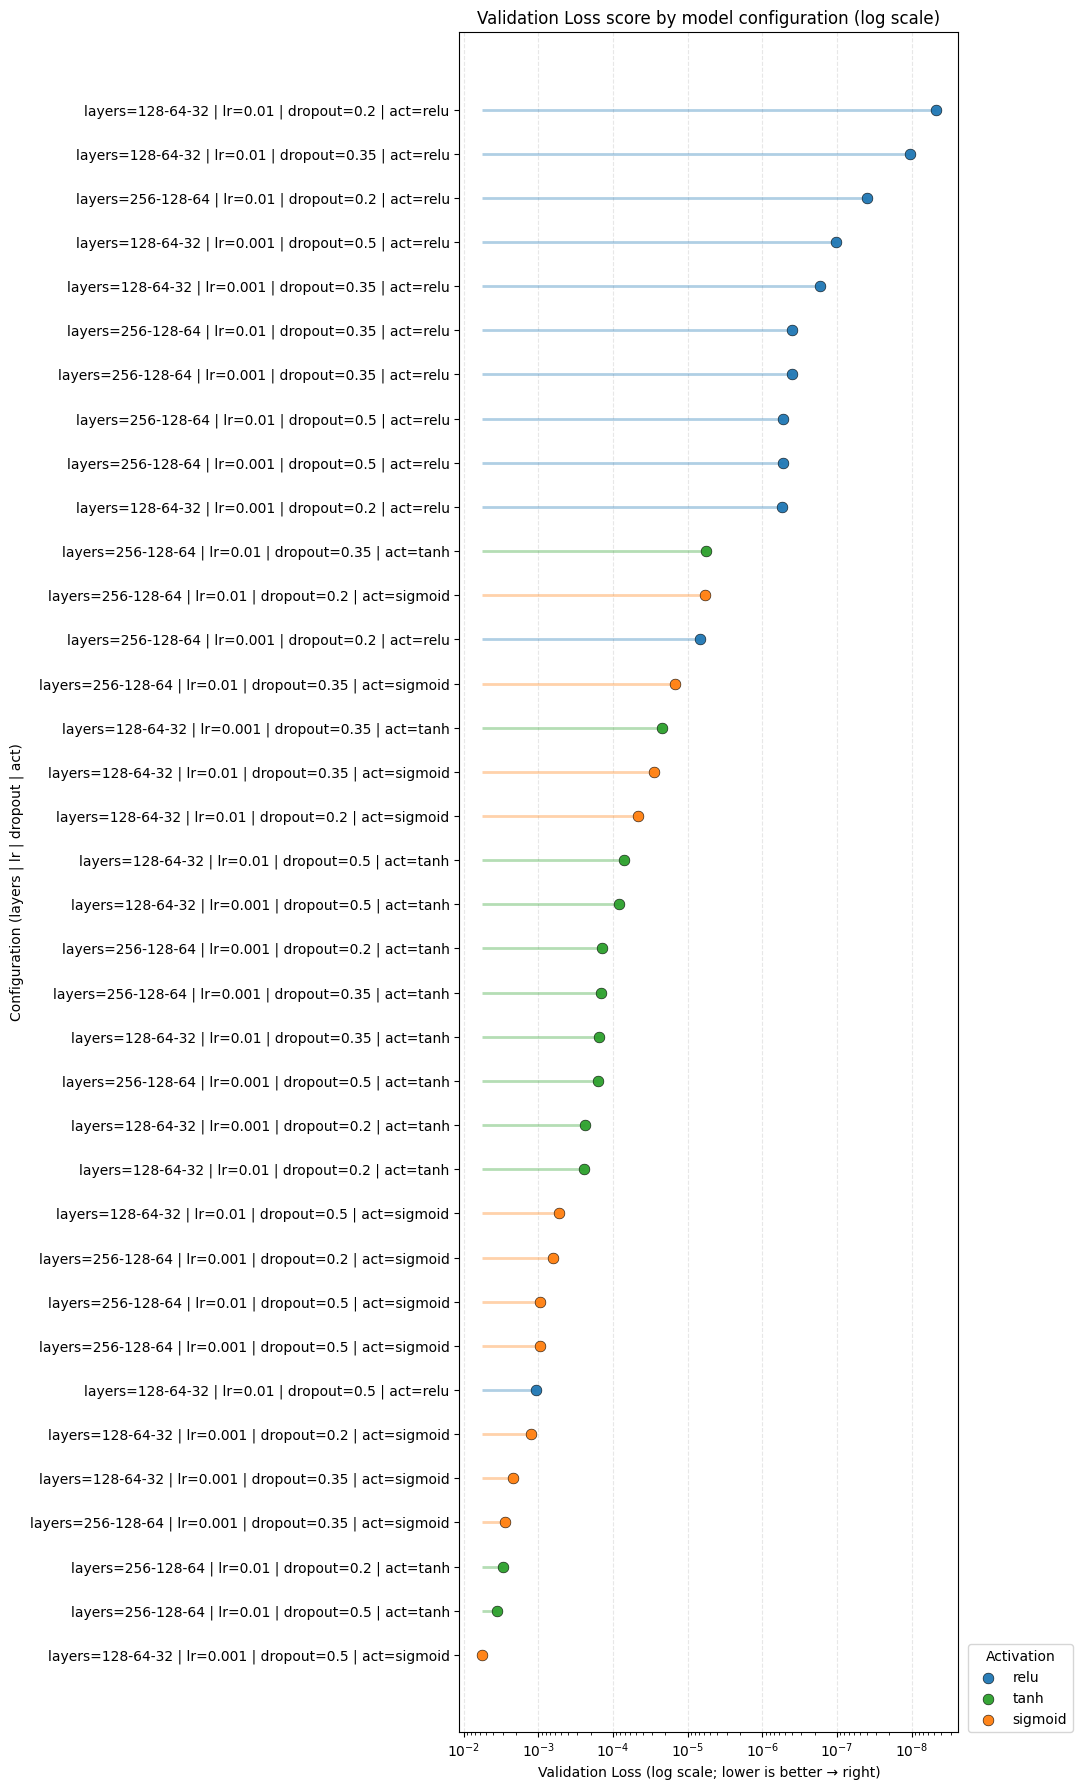

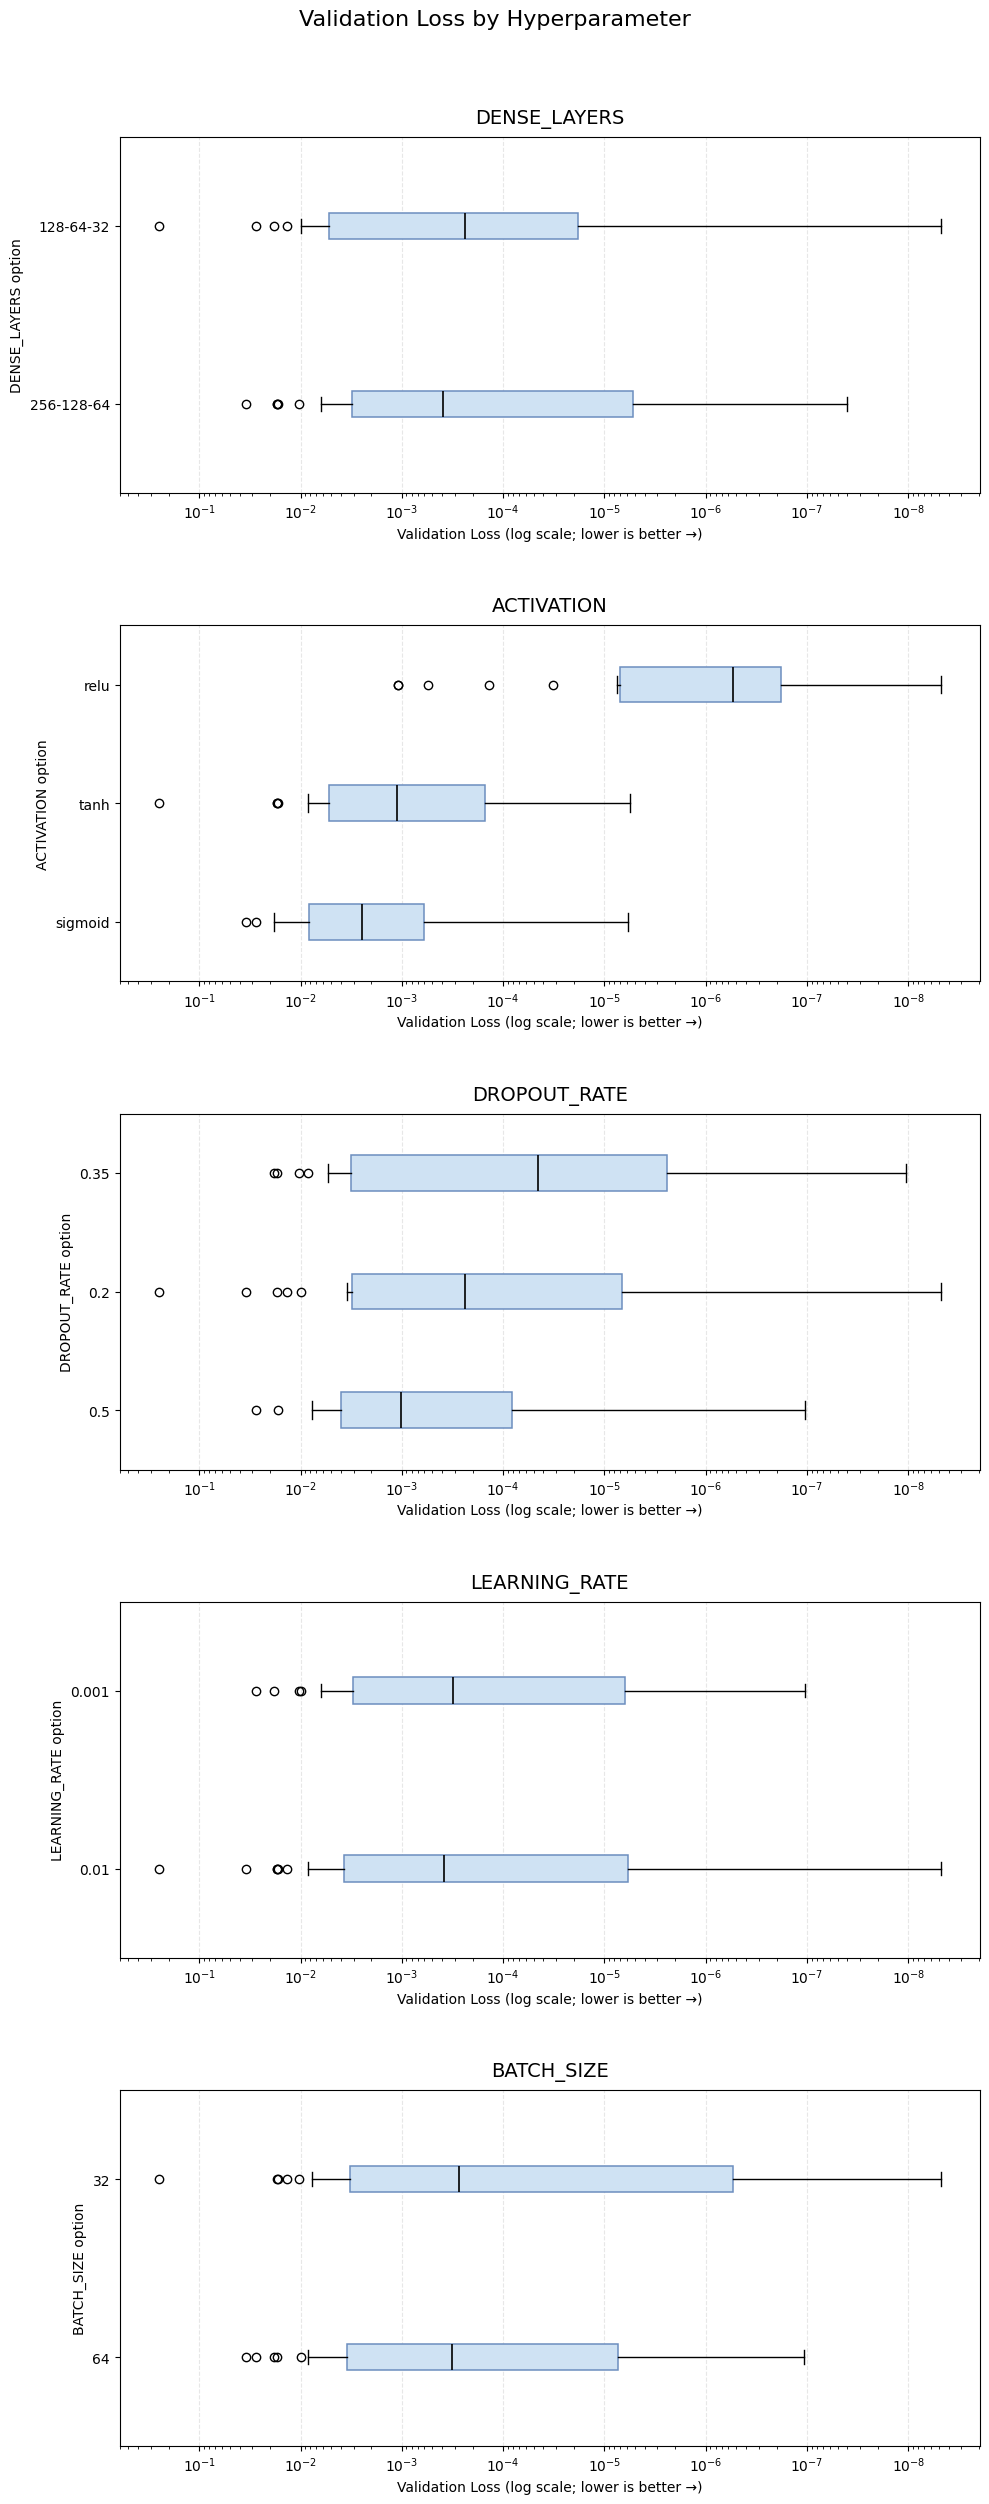

In [1]:
from src.gesture_controller.plot_helper import PlotHelper
from src.gesture_controller.app_config import AppConfig
import pandas as pd
import sys
import os

config = AppConfig()
paths = config.get_neural_network_config()
model_performance_path = paths.get('MODEL_PERFORMANCE_PATH')

df = pd.read_csv(model_performance_path)
plot_helper = PlotHelper()
plot_helper.plot_model_val_loss_score(df)
plot_helper.plot_val_loss_by_parameter(df)

<a id="evaluation"></a>
## 4. In-Depth Evaluation of the Best Model

Once the best-performing model has been identified from the hyperparameter search, we conduct a more detailed evaluation. This section focuses exclusively on the "winner" model to understand its learning dynamics, classification accuracy, and the structure of its predictions.

### Interpreting the Plots

The following code cell will generate several visualizations to assess the best model:

1.  **Training & Validation Curves (Loss and Accuracy)**: These plots show the model's loss and accuracy on both the training and validation sets over each epoch.
    *   **What to look for**: We want to see both curves converging. If the training loss/accuracy improves but the validation loss/accuracy stagnates or worsens, it's a sign of **overfitting**. A healthy model shows both curves improving and stabilizing.
2.  **Confusion Matrix**: This matrix provides a detailed breakdown of classification performance for each gesture.
    *   **How to read it**: The diagonal elements show the number of correct predictions for each class. Off-diagonal elements show where the model made mistakes (i.e., which gestures it confused with others). A perfect model would have a bright diagonal and dark off-diagonals.
3.  **ROC Curve (Receiver Operating Characteristic)**: This plot illustrates the diagnostic ability of the classifier as its discrimination threshold is varied.
    *   **What it means**: The Area Under the Curve (AUC) is a key metric. An AUC of 1.0 represents a perfect classifier, while an AUC of 0.5 represents a model with no discriminative power (equivalent to random guessing). We aim for curves that are pushed towards the top-left corner.
4.  **PCA and t-SNE Plots**: These are dimensionality reduction techniques used to visualize the high-dimensional landmark data in 2D.
    *   **What they show**: The plots show how the model's predictions cluster the data points. Well-separated clusters for each gesture indicate that the model has learned discriminative features and can distinguish between the classes effectively. Overlapping clusters may indicate which gestures are harder for the model to tell apart.

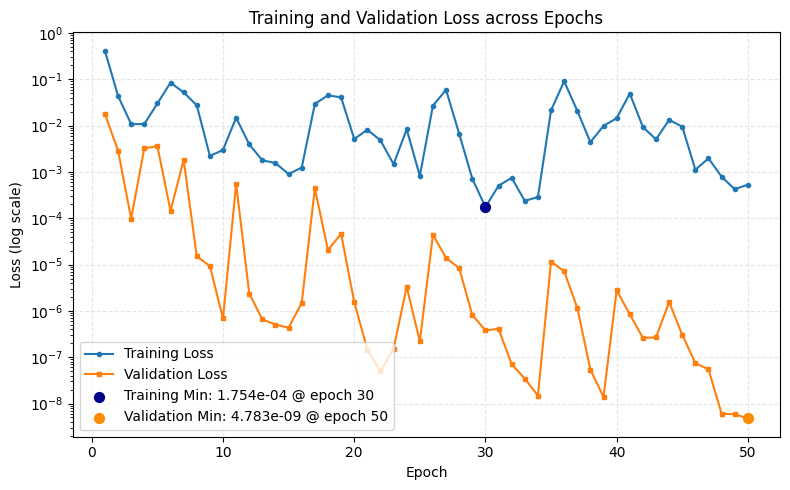

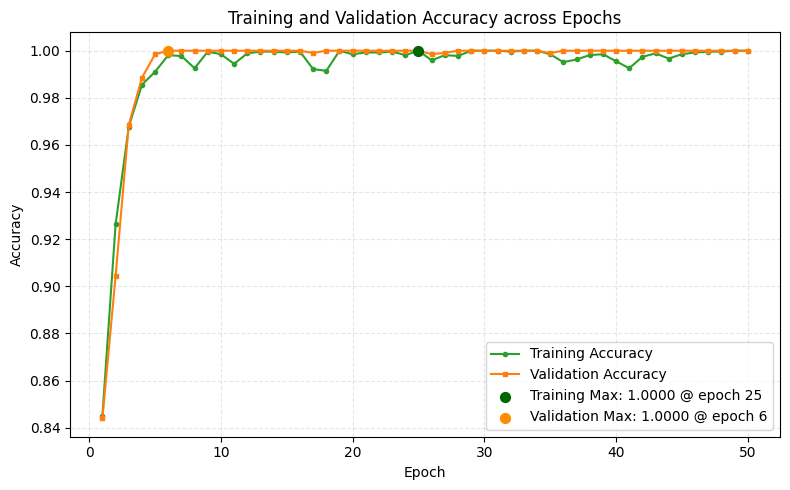

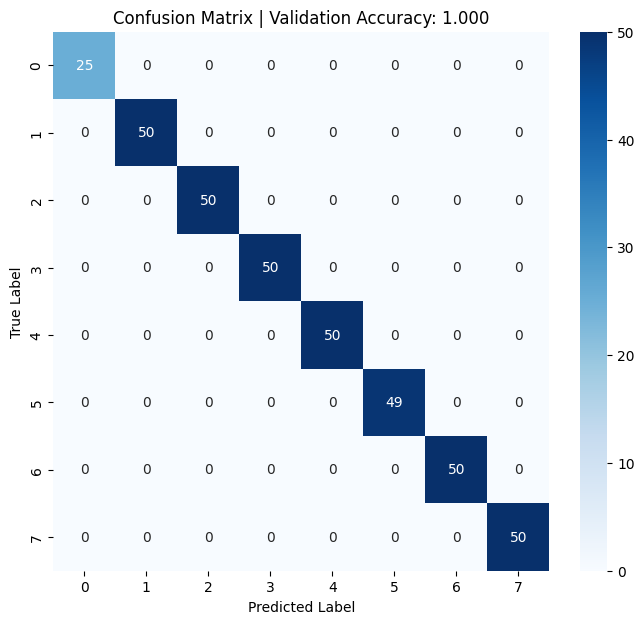

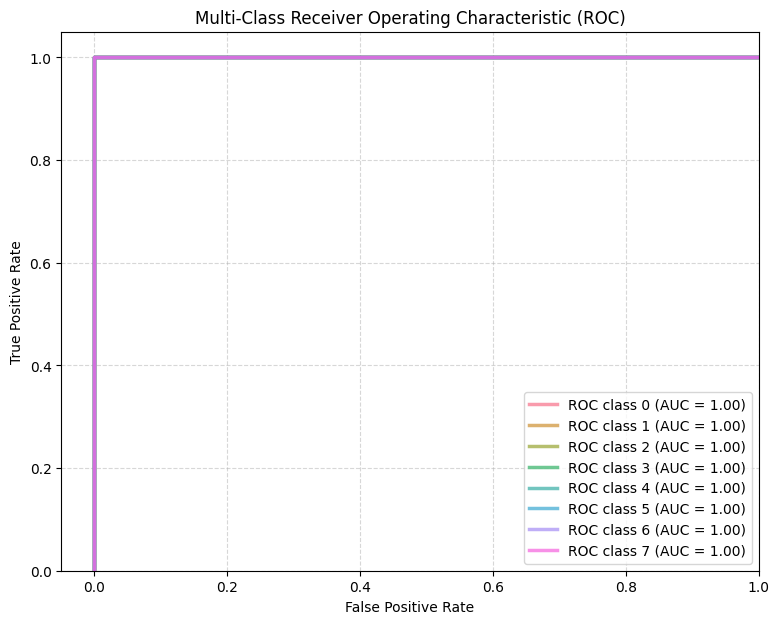

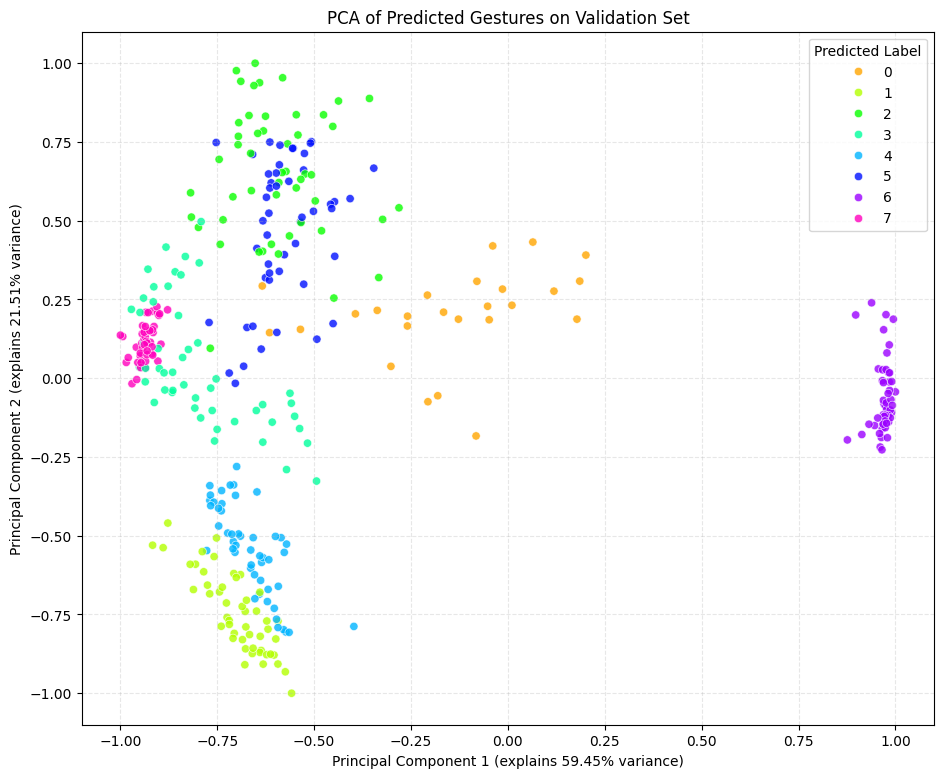

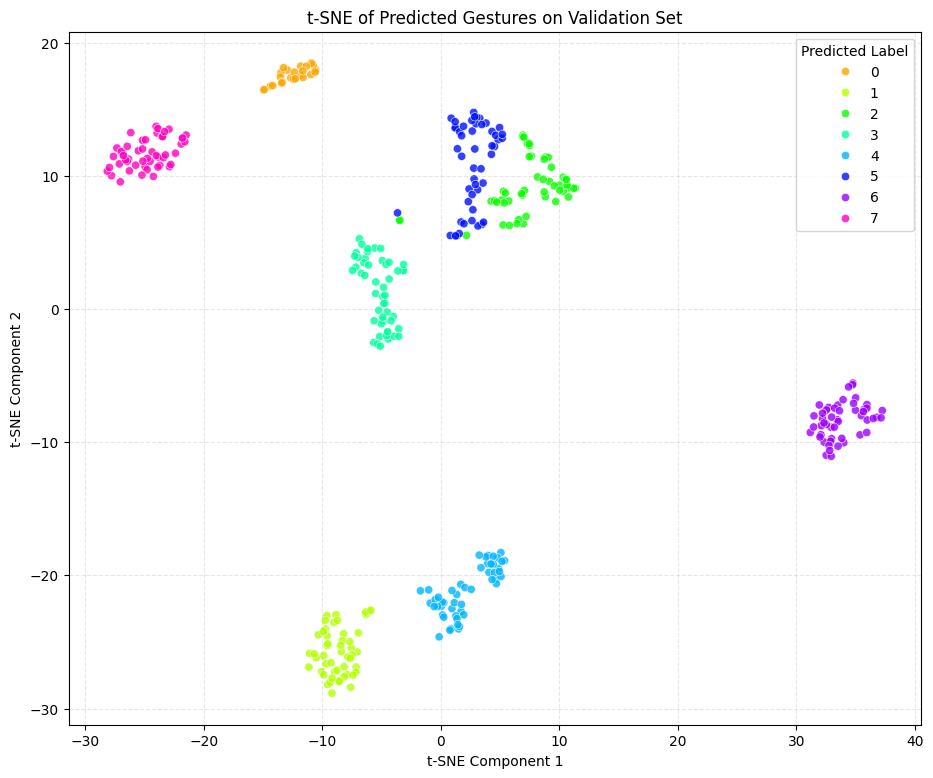

In [2]:
from src.gesture_controller.plot_helper import PlotHelper
from src.gesture_controller.app_config import AppConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import os

# Resolve paths from config
config = AppConfig()

data_generation_config = config.get_app_config("DATA_GENERATION_CONFIG")
datase_val_path = data_generation_config.get("DATASET_VAL_PATH")

nn_config = config.get_neural_network_config()
model_path = nn_config.get('MODEL_PATH')
model_performance_path = nn_config.get('MODEL_PERFORMANCE_PATH')


df = pd.read_csv(model_performance_path)
winner = df.sort_values(by=['val_accuracy', 'val_loss'], ascending=[False, True]).iloc[0]
plot_helper = PlotHelper()
plot_helper.plot_loss_in_epochs(winner)
plot_helper.plot_accuracy_in_epochs(winner)


# Load dataset
df = pd.read_csv(datase_val_path)
df['LANDMARKS'] = df['LANDMARKS'].apply(eval)
X = np.array(df['LANDMARKS'].tolist())
Y = df['GESTURE_ID'].to_numpy()

# Load model and predict
model = tf.keras.models.load_model(model_path)
probs = model.predict(X, verbose=0)
y_pred = np.argmax(probs, axis=1)

# Confusion matrix plot
classes = np.unique(Y)
plot_helper.plot_heatmap(Y, y_pred, classes)

# ROC plot
plot_helper.plot_roc_curve(Y, probs, classes)

# PCA Visualization plot
plot_helper.plot_pca(X, y_pred)

# t-SNE Visualization plot
plot_helper.plot_tsne(X, y_pred)